# Problem Statement

- This project aims at predicting house prices (residential) in Ames, Iowa, USA using advanced regression techniques.
- Train data consist of 1460 rows and 80 cols including target variable.
- Test data consist of 1459 rows and 79 cols.
- This dataset have lot of features to deal with. So, Feature Engineering comes to play.

# 1. Importing Libraries.

In [1]:
import numpy as np # Linear Algebra, Matrix operations .....etc
import pandas as pd # Data manipulation.
import seaborn as sns # Data Visualization.
import matplotlib.pyplot as plt # plots
%matplotlib inline 
#plot in jupyter notebook don't open new window for plotting.

# Future warnings ignore
import warnings
warnings.filterwarnings("ignore")

# Machine Learning API's
from sklearn.model_selection import cross_val_score # cross validation.
from sklearn.linear_model import LinearRegression,Lasso 
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor

# 2. Load data into pandas dataframe.

In [2]:
train_df=pd.read_csv("Dataset/train.csv") # train data
test_df=pd.read_csv("Dataset/test.csv") # test data.
train_df.head() # view top rows default 5 rows get displayed.

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
test_df.head() # view test data.

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# 3. Copy target variable to new variable.

In [4]:
target=train_df["SalePrice"].copy()
train_df.drop("SalePrice",axis=1,inplace=True) # Drop target from train dataset.

# 4. Combine train and test data.

In [5]:
df=pd.concat([train_df,test_df])

In [6]:
# check shape of combined data.
df.shape

(2919, 80)

- combined data has 2919 rows with 80 features

In [7]:
# Droping Id column
del df["Id"]

# 5. Check for missing values.
- Missing values treatment.

![](MissingValues.png)

In [8]:
null_cols=df.columns[df.isna().any()] # Get cols with missing values

In [9]:
null_per=round(df[null_cols].isna().agg("mean").sort_values(ascending=False),5) # Get percentage of missing values of each column.

In [10]:
null=pd.DataFrame({"Features":null_per.index,"percentage":null_per.values}) # create data frame  for barplot.

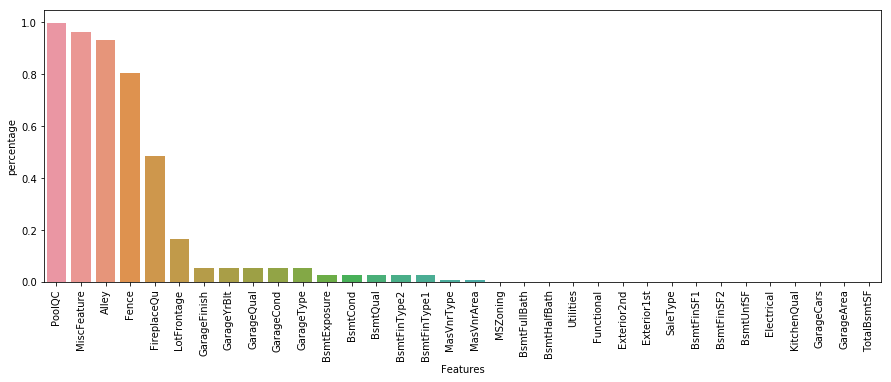

In [11]:
plt.figure(figsize=(15,5)) # set width and height for plot
sns.barplot(x=null.columns[0],y=null.columns[1],data=null)
plt.xticks(rotation = 90) # Prevent labels from overlapping.
plt.show()

- PoolQC Followed by MiscFeature and Alley, Fence features having highest percentage of missing values above 50%. 

In [12]:
# Drop features with 50% values missing in it.
df.dropna(thresh=int(0.5*len(df)),inplace=True,axis=1)

In [13]:
df.shape # shape after dropping cols.

(2919, 75)

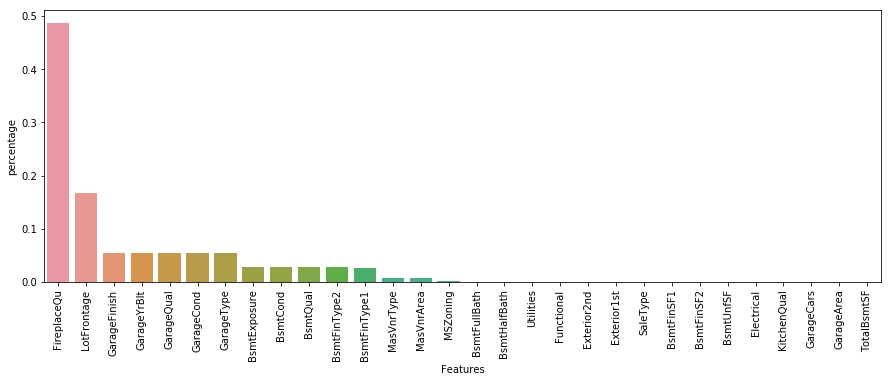

In [14]:
rem_null=null[4:]# Get remaining missing values which are less than 50%.
plt.figure(figsize=(15,5)) # set width and height for plot
sns.barplot(x=rem_null.columns[0],y=rem_null.columns[1],data=rem_null)
plt.xticks(rotation = 90) # Prevent labels from overlapping.
plt.show()

# we need to impute this missing values 
- You need to have good understanding of each variable.
- Three types of missing data mechanisms - MCAR, MAR, MNAR.
   1. Missing completely at random (MCAR) - Missingness is not related to any variables. Missingness on variable is completely unsystematic.
   2. Missing at random (MAR) - Missingness is related to other variables not itself. it can be imputated with other variables which relates to missing                                 data.
   3. Missing not at random (MNAR) - Also know as "non-ignorable" because should not be ignored. this shows up when neither MCAR or MAR and it's related                                      to both observed(Missing) and unobserved(other features) data.
- MCAR and MAR is found by statistical testing.
- MNAR is found by understanding data.

# Imputing numeric features.

In [15]:
# Get numeric features and store into new variable
numeric_features=df.select_dtypes(include=np.number)

In [16]:
numeric_features.dtypes.value_counts() # check dtypes.

int64      25
float64    11
dtype: int64

In [17]:
# Imputation using KNN it finds similar values to impute missing ones.
from fancyimpute import KNN
impute=KNN(k=3).fit_transform(numeric_features) # imputing

Using TensorFlow backend.


Imputing row 1/2919 with 0 missing, elapsed time: 8.725
Imputing row 101/2919 with 1 missing, elapsed time: 8.729
Imputing row 201/2919 with 0 missing, elapsed time: 8.734
Imputing row 301/2919 with 0 missing, elapsed time: 8.737
Imputing row 401/2919 with 0 missing, elapsed time: 8.741
Imputing row 501/2919 with 0 missing, elapsed time: 8.745
Imputing row 601/2919 with 0 missing, elapsed time: 8.749
Imputing row 701/2919 with 0 missing, elapsed time: 8.753
Imputing row 801/2919 with 0 missing, elapsed time: 8.757
Imputing row 901/2919 with 1 missing, elapsed time: 8.761
Imputing row 1001/2919 with 0 missing, elapsed time: 8.765
Imputing row 1101/2919 with 0 missing, elapsed time: 8.769
Imputing row 1201/2919 with 0 missing, elapsed time: 8.774
Imputing row 1301/2919 with 1 missing, elapsed time: 8.778
Imputing row 1401/2919 with 0 missing, elapsed time: 8.782
Imputing row 1501/2919 with 1 missing, elapsed time: 8.786
Imputing row 1601/2919 with 0 missing, elapsed time: 8.790
Imputing 

> - **NOTE**: It returns series of numpy arrays and convert whole data dtypes into float you need to convert back original dtypes.

In [18]:
# Creating dataframe because knn imputation returns series of numpy arrays.
imputed=pd.DataFrame(impute,columns=numeric_features.columns)
imputed.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0


In [19]:
cast_int=imputed.dtypes[numeric_features.dtypes != imputed.dtypes] # Get dtypes to change into int format.
imputed[cast_int.index]=imputed[cast_int.index].applymap(int) # casting into original dtypes.

In [20]:
imputed.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,608.0,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,642.0,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,836.0,192,84,0,0,0,0,0,12,2008


In [21]:
imputed.dtypes.value_counts() # count of dtypes

int64      25
float64    11
dtype: int64

In [22]:
# check you imputated to null values
imputed.isna().any().sum()

0

In [23]:
# Statistical information of numeric data.
imputed.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,70.084553,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.291005,441.318048,49.565262,...,472.886959,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,22.945779,7886.996359,1.409947,1.113131,30.291442,20.894344,178.908743,455.568198,169.179104,...,215.358944,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,20.999999,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,60.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,70.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.000000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


# Imputing categorical columns.

In [24]:
# Check for missingness count
cate_features=df.select_dtypes(exclude=np.number)
cate_cols=cate_features.columns[cate_features.isna().any()]
cate_per=round(df[cate_cols].isna().agg("mean").sort_values(ascending=False),5) # Get percentage of missing values of each column.
cate_per

FireplaceQu     0.48647
GarageQual      0.05447
GarageFinish    0.05447
GarageCond      0.05447
GarageType      0.05379
BsmtExposure    0.02809
BsmtCond        0.02809
BsmtQual        0.02775
BsmtFinType2    0.02741
BsmtFinType1    0.02706
MasVnrType      0.00822
MSZoning        0.00137
Functional      0.00069
Utilities       0.00069
Electrical      0.00034
KitchenQual     0.00034
Exterior2nd     0.00034
Exterior1st     0.00034
SaleType        0.00034
dtype: float64

In [25]:
cate_features[cate_cols].isna().sum()

MSZoning           4
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
SaleType           1
dtype: int64

In [26]:
cate_features["FireplaceQu"]=cate_features["FireplaceQu"].fillna("Missing")
cols=cate_features[cate_cols].isna().sum() <100
impute_cols=cols.index
for i in impute_cols:
    cate_features[i].fillna(cate_features[i].mode()[0],inplace=True)

In [27]:
cate_features[cate_cols].isna().sum()

MSZoning        0
Utilities       0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
KitchenQual     0
Functional      0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
SaleType        0
dtype: int64

In [28]:
cate_features.columns.value_counts().sum()

39

# 6. Data exploration

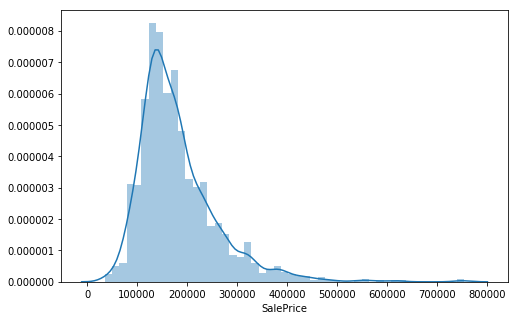

In [29]:
# check distribution of target variable.
plt.figure(figsize=(8,5))
sns.distplot(target)

- It is right skewed or positive skewed. 
- Check skewness of target feature.

In [30]:
target.skew() # skewness

1.8828757597682129

0.12133506220520406

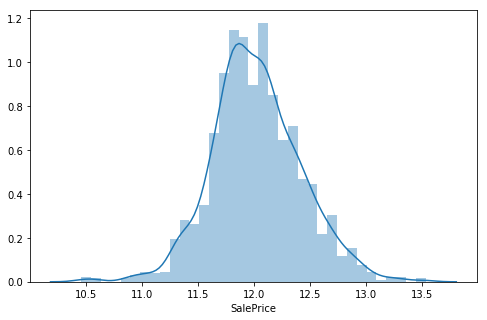

In [31]:
# converting right skewed to normal distribution (or) close to normal.
plt.figure(figsize=(8,5))
sns.distplot(np.log(target))
np.log(target).skew()

> Converting target from right skewed to normal will helps model to map relationship between independent variables to target variable. 

In [32]:
recombined=pd.concat([numeric_features,cate_features],axis=1)

In [33]:
recombined.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,Gd,Typ,Missing,Attchd,RFn,TA,TA,Y,WD,Normal
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


# 7. Corelation between numeric variables

In [34]:
train=recombined[:train_df.shape[0]]
test=recombined[train_df.shape[0]:]
train.shape,test.shape

((1460, 75), (1459, 75))

In [35]:
trainn=pd.concat([train,target],axis=1)

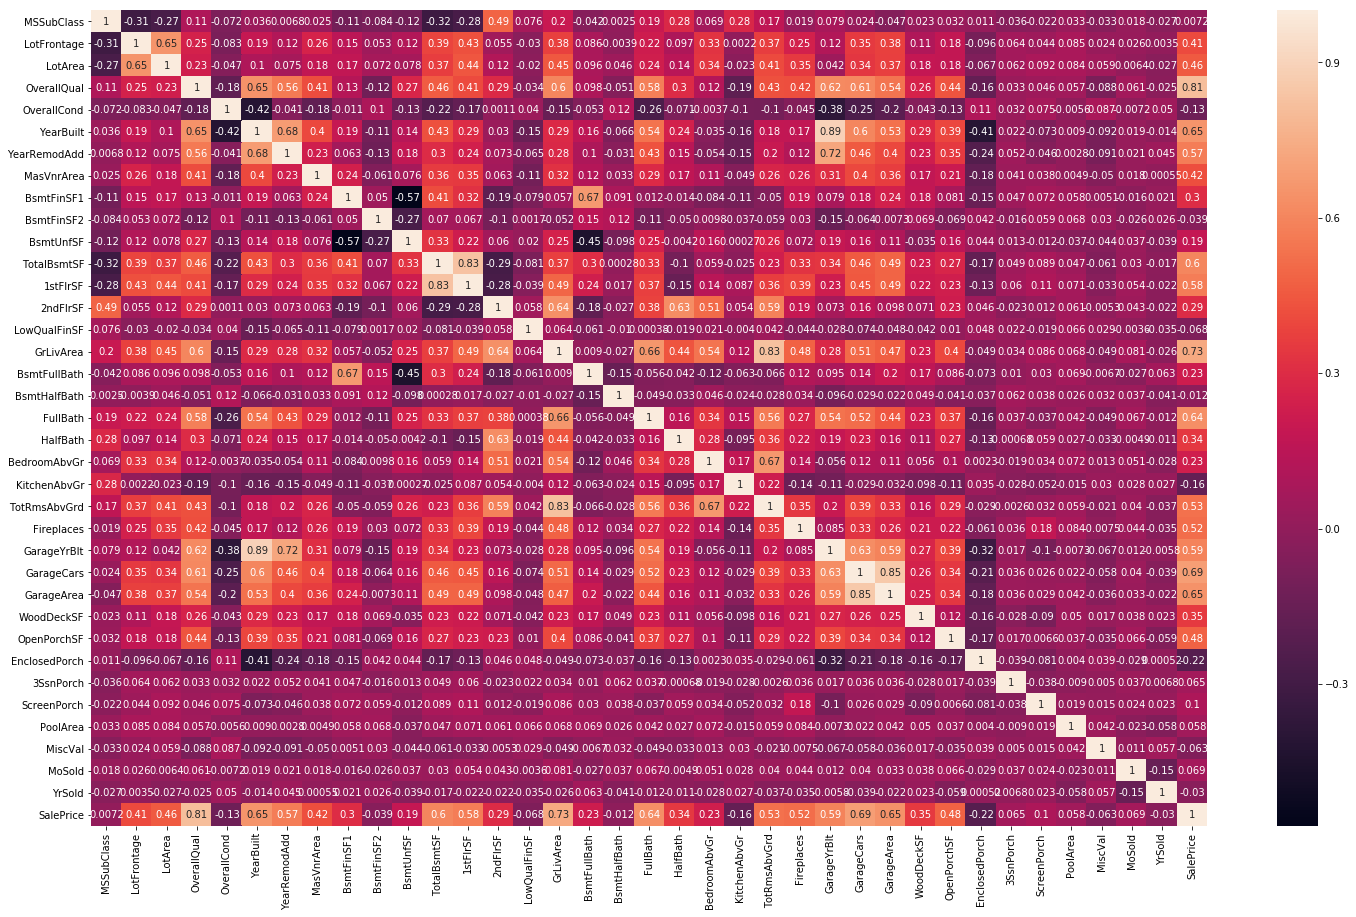

In [36]:
plt.figure(figsize=(25,15))
corr=trainn.corr(method="spearman")
sns.heatmap(corr,annot=True)

In [37]:
print (corr['SalePrice'].sort_values(ascending=False)[:20]) #top 15 values
print ('----------------------')
print (corr['SalePrice'].sort_values(ascending=False)[-5:]) #last 5 values`

SalePrice       1.000000
OverallQual     0.809829
GrLivArea       0.731310
GarageCars      0.690711
YearBuilt       0.652682
GarageArea      0.649379
FullBath        0.635957
TotalBsmtSF     0.602725
GarageYrBlt     0.593788
1stFlrSF        0.575408
YearRemodAdd    0.571159
TotRmsAbvGrd    0.532586
Fireplaces      0.519247
OpenPorchSF     0.477561
LotArea         0.456461
MasVnrArea      0.421309
LotFrontage     0.409076
WoodDeckSF      0.353802
HalfBath        0.343008
BsmtFinSF1      0.301871
Name: SalePrice, dtype: float64
----------------------
MiscVal         -0.062727
LowQualFinSF    -0.067719
OverallCond     -0.129325
KitchenAbvGr    -0.164826
EnclosedPorch   -0.218394
Name: SalePrice, dtype: float64


# Visualize the relation between correlated variables with target.

In [38]:
# 1st correlated variable.
trainn['OverallQual'].unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

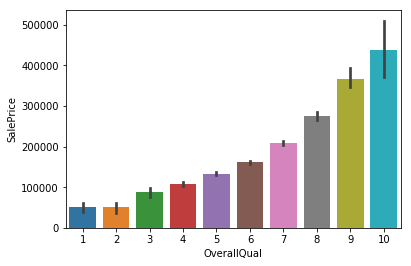

In [39]:
#let's check the mean price per quality and plot it.
pivot = trainn.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)
sns.barplot(x="OverallQual",y="SalePrice",data=trainn)

- Overall quality increases saleprice also increases

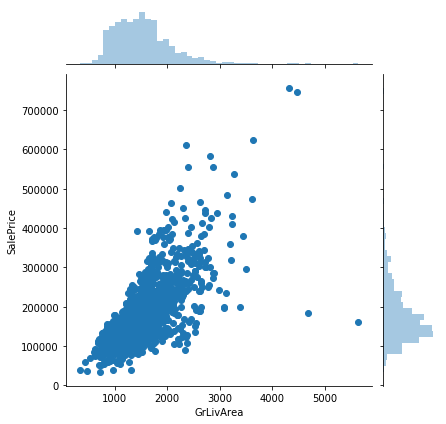

In [40]:
pivot = trainn.pivot_table(index='GrLivArea', values='SalePrice', aggfunc=np.median)
sns.jointplot(x="GrLivArea",y="SalePrice",data=trainn)

- It consist of outliers, outliers spoil the model .we need to analyse it and then decide remove or leave.
- we are using advanced regression models randomforest,xgboost they handle outliers.
- Likewise, analyse other variables which are correlated with target.

# Analysing categorical variables.

In [41]:
cate_data=recombined.select_dtypes(include="object")
cate_data.describe()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
count,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,...,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919
unique,5,2,4,4,2,5,3,25,9,8,...,4,7,6,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,TA,Typ,Missing,Attchd,Unf,TA,TA,Y,WD,Normal
freq,2269,2907,1859,2622,2918,2133,2778,443,2511,2889,...,1493,2719,1420,1880,1389,2763,2813,2641,2526,2402


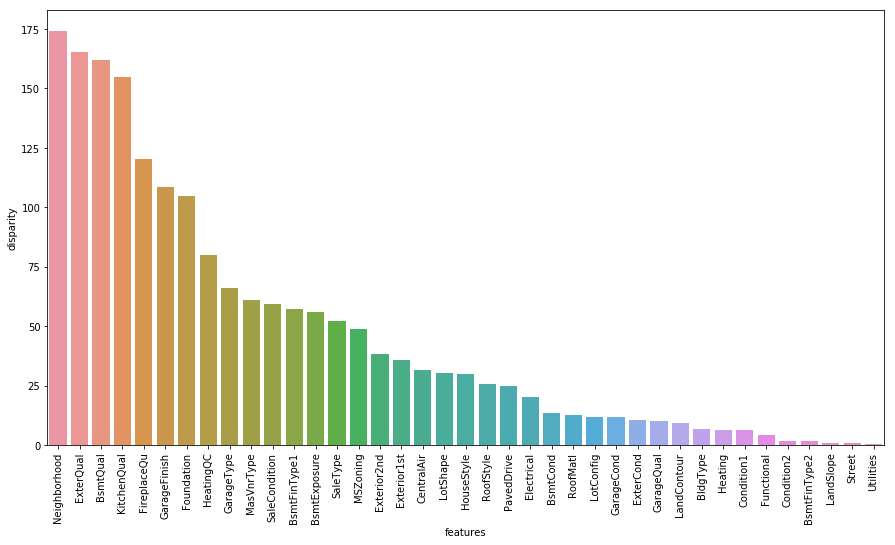

In [42]:
# we need to check the relation between categorical values using ANOVA .
from scipy import stats
cat = [f for f in trainn.columns if trainn.dtypes[f] == 'object']
def anova(frame):
    anv = pd.DataFrame()
    anv['features'] = cat
    pvals = []
    for c in cat:
           samples = []
           for cls in frame[c].unique():
                  s = frame[frame[c] == cls]['SalePrice'].values
                  samples.append(s)
           pval = stats.f_oneway(*samples)[1]
           pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

cate_data['SalePrice'] = trainn.SalePrice
k = anova(cate_data) 
k['disparity'] = np.log(1./k['pval'].values) 
plt.figure(figsize=(15,8))
sns.barplot(data=k, x = 'features', y='disparity') 
plt.xticks(rotation=90) 
plt.show()

- Here we see that among all categorical variables Neighborhood turned out to be the most important feature followed by ExterQual, KitchenQual, etc.  

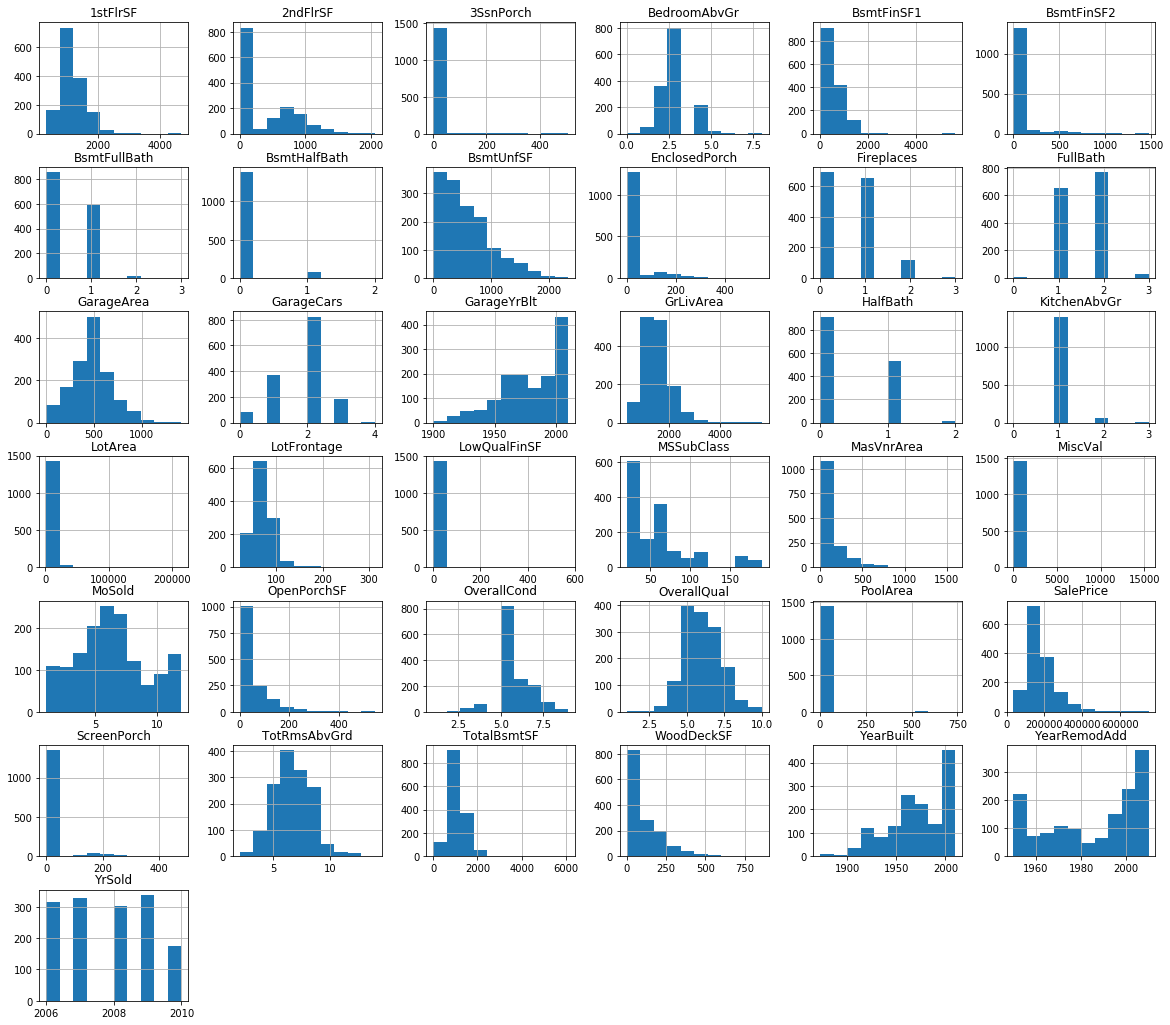

In [43]:
# View all numeric features distribution.
trainn.hist(figsize=(20,18))
plt.show()

- Check if target variable distribution is matching with independent variables.

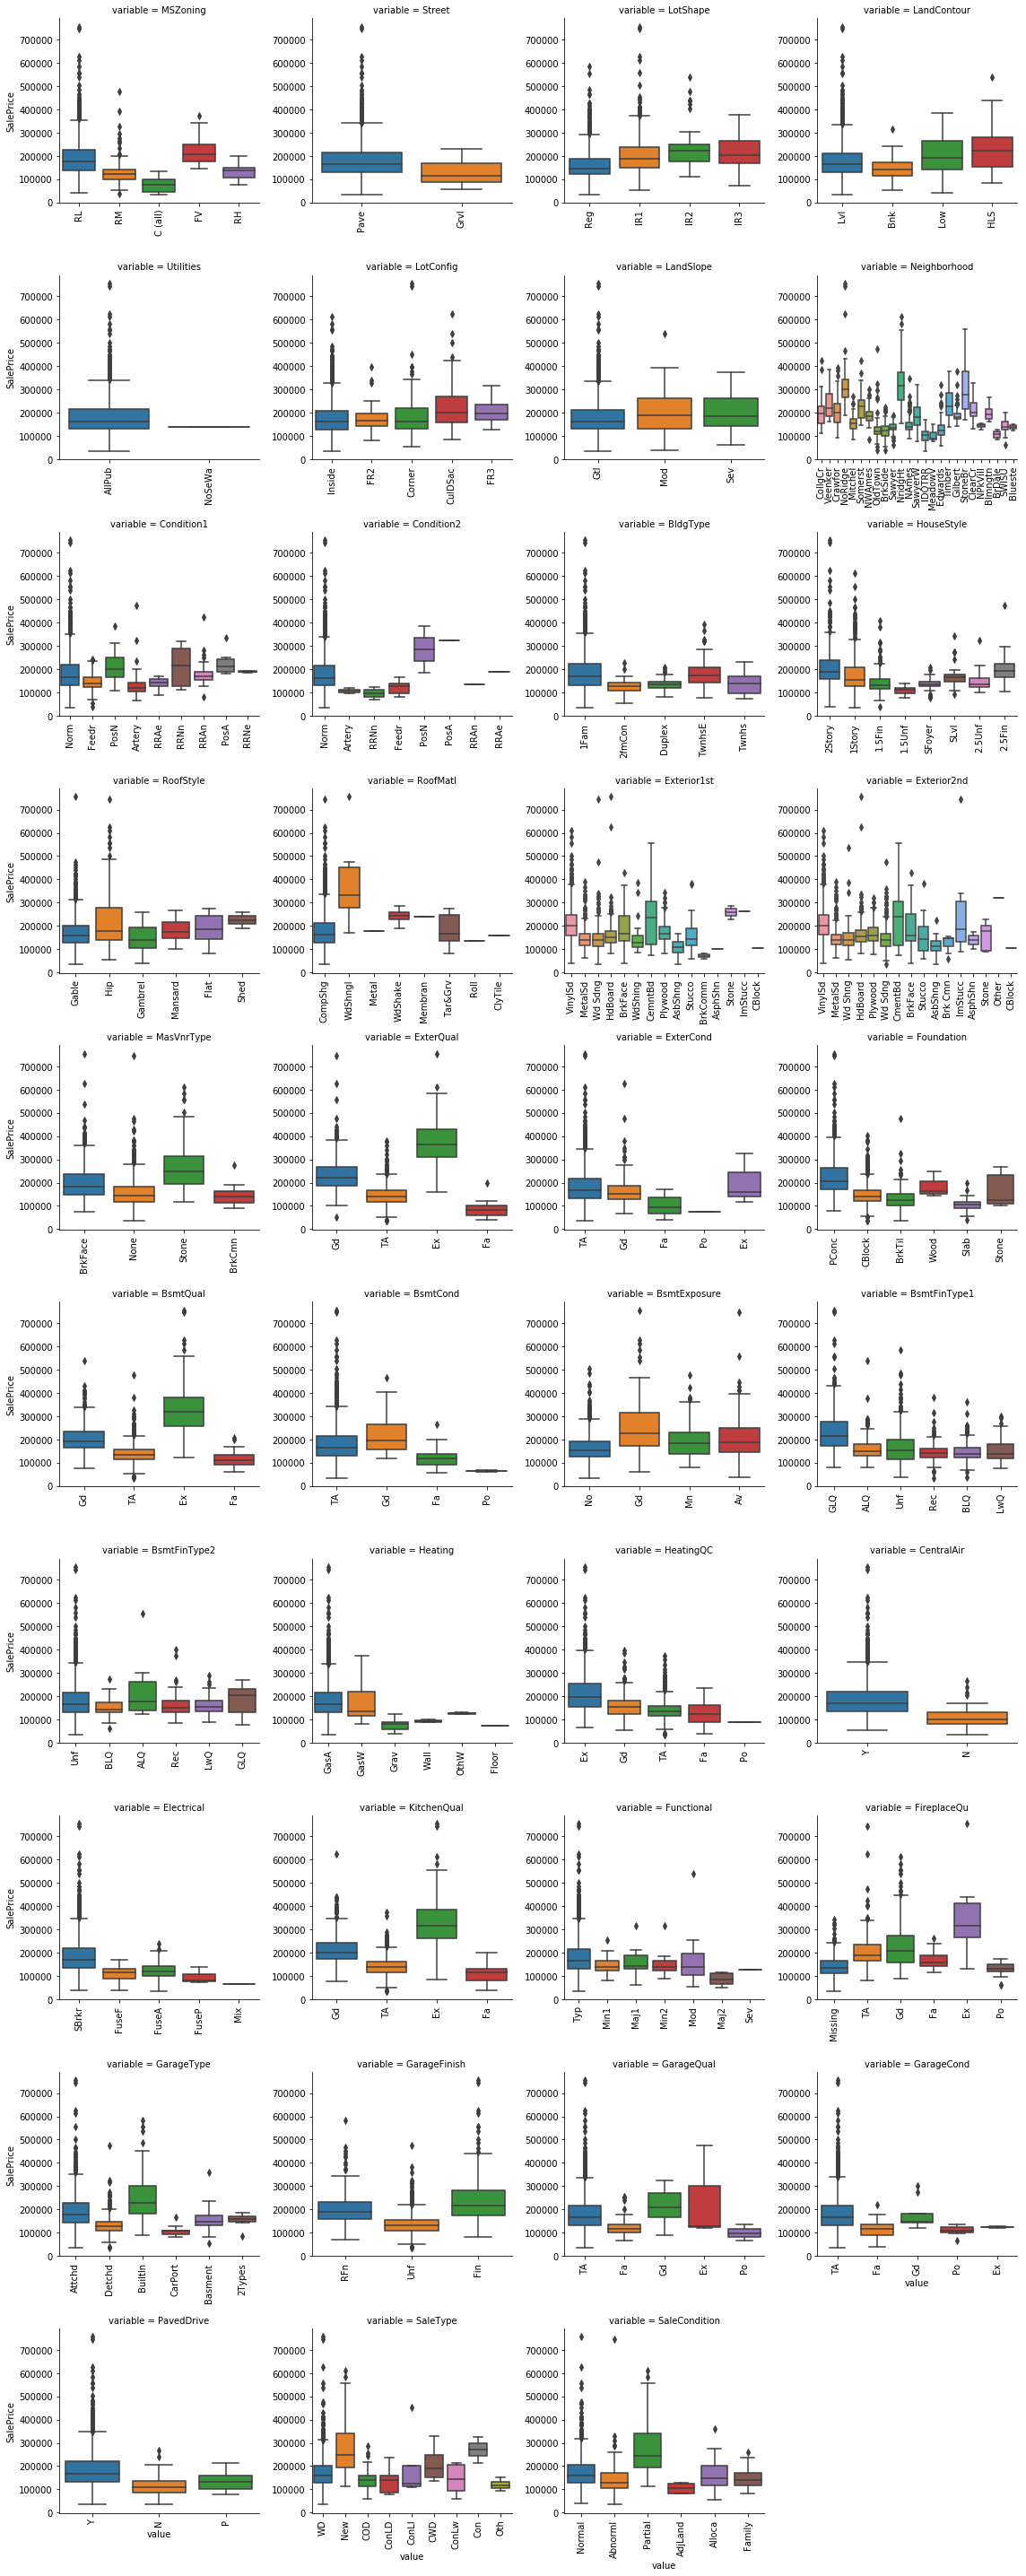

In [44]:
# Also visualize the categorical variables using boxplot
def boxplot(x,y,**kwargs):
            sns.boxplot(x=x,y=y)
            x = plt.xticks(rotation=90)

cat = [f for f in train.columns if trainn.dtypes[f] == 'object']

p = pd.melt(trainn, id_vars='SalePrice', value_vars=cat)
g = sns.FacetGrid (p, col='variable', col_wrap=4, sharex=False, sharey=False, height=4)
g = g.map(boxplot, 'value','SalePrice')
g

# 8. Feature engineering

In [45]:
# we need to convert categorical variables in to numeric. unless it gives you any error all models works with numerical mathematical formuales.
# combine train and test data ,split target into new variable
target=trainn["SalePrice"].copy()
del trainn["SalePrice"]
fina_df=pd.concat([trainn,test])

In [46]:
# Look out features behavior and perform feature engineering.
# Select features which contribute to target variable and also create new .

fina_df.select_dtypes(include="object").nunique() # unique values in each categorical variable.

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       6
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

- we need to convert this values into numeric by label encoding and one-hot encoding.
- Also you should know the difference between label encoding and OHE
- label assumes assumes they are ordinal values. it should be appiled to only ordinal data.
- OHE extends the dimensionality of data should be used wisely.

In [ ]:
# perfrom label encoding on ordinal data or mapping function.
# features which are have quality are ordinal.
features_ord=["GarageQual","KitchenQual","FireplaceQu","BsmtQual","ExterQual"]
fina_df[features_ord].nunique()

In [ ]:
# multiple column label encoder class
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [ ]:
fina_df=MultiColumnLabelEncoder(columns = features_ord).fit_transform(fina_df)

In [ ]:
fina_df.head()

In [47]:
# converting other categorical values to numeric using OHE , pandas get_dummies.
fina_df=pd.get_dummies(fina_df)

In [48]:
# splitting train and test data.
train_split=fina_df[:train_df.shape[0]]
test_split=fina_df[train_df.shape[0]:]

In [49]:
# log transformation target before training
y=np.log(target)

In [50]:
train_split.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [51]:
# some cols still have null values that are hidden by imputation methods.
remaining=train_split.columns[train_split.isna().any()]
remaining

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [52]:
for i in remaining:
    train_split[i].fillna(0,inplace=True) # Filling with zeros

In [53]:
remaining=test_split.columns[test_split.isna().any()]
for i in remaining:
    test_split[i].fillna(0,inplace=True) # filling with zeros

In [54]:
# final check for null values in both train and test data.
print(train_split.columns[train_split.isna().any()])
print(test_split.columns[test_split.isna().any()])

Index([], dtype='object')
Index([], dtype='object')


In [63]:
from sklearn.preprocessing import StandardScaler
stand=StandardScaler()
values=stand.fit_transform(train_split)
X_train=pd.DataFrame(values,columns=train_split.columns)

In [64]:
from sklearn.preprocessing import StandardScaler
stand=StandardScaler()
values=stand.fit_transform(test_split)
X_test=pd.DataFrame(values,columns=test_split.columns)

# 9. Model building.
- Using 3 models Xgboost, Lasso, Gradient Boosting.

In [65]:
import xgboost as xgb
# below parameters are valued by cross-validation.
regr = xgb.XGBRegressor(colsample_bytree=0.2,
                       gamma=0.0,
                       learning_rate=0.05,
                       max_depth=6,
                       min_child_weight=1.5,
                       n_estimators=7200,
                       reg_alpha=0.9,
                       reg_lambda=0.6,
                       subsample=0.2,
                       seed=42,
                       silent=1)

regr.fit(X_train, y) # train data, log transformed target.

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1.5, missing=None, n_estimators=7200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.9, reg_lambda=0.6, scale_pos_weight=1, seed=42,
             silent=1, subsample=0.2, verbosity=1)

In [66]:
from sklearn.metrics import mean_squared_error
# root mean square error function
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred)) 

# Run prediction on training set to get an idea of how well it does
y_pred = regr.predict(X_train)
y_test = y
print("XGBoost score on training set: ", rmse(y_test, y_pred))

XGBoost score on training set:  0.042615231904726616


In [67]:
# make prediction on the test set
y_pred_xg = regr.predict(X_test)
xg_ex = np.exp(y_pred_xg)
pred1 = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': xg_ex})
pred1.to_csv('xgboost.csv', header=True, index=False)

### Lasso Regression.

In [68]:
# Lasso
from sklearn.linear_model import Lasso

# found this best alpha through cross-validation
best_alpha = 0.00099

lasso = Lasso(alpha=best_alpha, max_iter=50000)
lasso.fit(X_train, y)

# Metrics score on train data
y_pred = lasso.predict(X_train)
y_test = y
print("Lasso score on training set: ", rmse(y_test, y_pred))

Lasso score on training set:  0.09728663677370437


In [69]:
#make prediction on the test set
lasso_pred = lasso.predict(X_test)
lasso_ex = np.exp(lasso_pred)
pred1 = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': lasso_ex})
pred1.to_csv('lasso.csv', header=True, index=False)

### Gradient Boosting Regressor

In [70]:
# Gradient boosting regressor model training
from sklearn.ensemble import GradientBoostingRegressor
est = GradientBoostingRegressor(n_estimators= 1000, max_depth= 2, learning_rate= .01)
est.fit(X_train, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [71]:
# metrics score on train data.
y_pred = est.predict(X_train)
y_test = y
print("Gradient score on training set: ", rmse(y_test, y_pred))

Gradient score on training set:  0.10254148098784402


In [73]:
# submission to kaggle
GBC_pred = est.predict(X_test) # prediction
GBC_ex = np.exp(GBC_pred) # converting back to original values
pred1 = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': GBC_ex})
pred1.to_csv('GBC.csv', header=True, index=False)